In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pickle
import torch
import torch.nn as nn

from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from os.path import join
from scipy.stats import binom

import sys
sys.path.append(os.getcwd() + "/../")
from gatsbi.task_utils.RedSea import Simulator, Generator
from gatsbi.networks import WrapGenMultipleSimulations
from gatsbi.utils import compute_calibration_metrics, generate_test_set_for_calibration, \
    generate_test_set_for_calibration_from_obs
from gatsbi.task_utils.RedSea import Prior

# Calibration measures


In [2]:
from copy import deepcopy
from tabulate import tabulate

## Download data from WANDB
And put them in dataframes

In [3]:
import pandas as pd
import wandb
api = wandb.Api()

def obtain_wandb_data(project):
    runs_list = []
    new_dict_list = []

    # Project is specified by <entity/project-name>
    runs = api.runs("bencekaszas/" + project)
    
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_dict = run.summary._json_dict

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_dict = {k: v for k, v in run.config.items()
                        if not k.startswith('_')}

        # .name is the human-readable name of the run.
        new_dict = {"name": run.name, "ID": run.id, **config_dict, **summary_dict}
        new_dict_list.append(new_dict)           

    runs_list.append(pd.DataFrame(new_dict_list))

    return runs_list


runs_list = obtain_wandb_data("RedSea-COLAB")


In [4]:
runs_list = runs_list[0].sort_values("name")

In [5]:
runs_list.columns

Index(['name', 'ID', 'epochs', 'patch_size', 'patch_step', 'patched_sr',
       'sample_seed', 'gen_opt_args', 'path_to_data', 'scoring_rule',
       'hold_out_perc', 'log_dataloader', 'batch_size_perc',
       'num_training_simulations', 'num_simulations_generator', '_runtime',
       'gen_grad', 'gen_loss', '_timestamp', 'kernel_bandwidth',
       'early_stop_at_epoch', 'r2_val_std', 'rmse_val_std', 'cal_err_val_mean',
       'train_time', 'r2_val_mean', 'cal_err_val_std', '_step', '_wandb',
       'sbc_lines', 'global_step', 'rmse_val_mean'],
      dtype='object')

In [6]:
runs_list

,name,ID,epochs,patch_size,patch_step,patched_sr,sample_seed,gen_opt_args,path_to_data,scoring_rule,...,rmse_val_std,cal_err_val_mean,train_time,r2_val_mean,cal_err_val_std,_step,_wandb,sbc_lines,global_step,rmse_val_mean
1,Energy-20-cpu,0oe3bjhk,20000,None,None,False,42,"[0.0001, [0.9, 0.99]]",./data_RedSea/,energy_score,...,0.029192,0.075250,1404.059407,0.148774,0.069059,8,{'runtime': 1858},"{'_type': 'image-file', 'width': 800, 'format'...",1200,0.263760
0,Kernel-20-cpu,y6mh3zrt,20000,None,None,False,42,"[0.0001, [0.9, 0.99]]",./data_RedSea/,kernel_score,...,0.029227,0.255875,1672.383800,0.195382,0.161291,10,{'runtime': 2117},"{'_type': 'image-file', 'width': 800, 'format'...",1400,0.256877


## Now print all results as Table


In [7]:
def print_table(df, latex=False, file=None, tranpose=False):

    metrics = [['rmse_val_std', 'rmse_val_mean'], ['cal_err_val_std', 'cal_err_val_mean'],
                   ['r2_val_std', 'r2_val_mean'], ['_runtime'], ['global_step']]
    metric_names = [r"NRMSE $ \downarrow $", r"Cal. Err. $ \downarrow $", r"R$^2$ $ \uparrow $", "Runtime (sec)", "Early stopping epoch"]
    
    df_dict = df.to_dict("list")
    
    name_list = [""] + [name.replace("RedSea", "").replace("_", " ").replace("score", "") for name in df_dict["name"]]
    
    all_lists = []
    all_lists.append(name_list)

    for name, metric in zip(metric_names, metrics): 
        inner_list = [name]    

        if len(metric) == 2:
            inner_list += [f"{df_dict[metric[1]][i]:.2f} $\pm$ {df_dict[metric[0]][i]:.2f}" for i in range(len(df_dict[metric[0]]))]
        else:
            inner_list += [f"{df_dict[metric[0]][i]:.2f}" for i in range(len(df_dict[metric[0]]))]
                
        all_lists.append(deepcopy(inner_list))

    if tranpose: 
        all_lists = list(map(list, zip(*all_lists)))
    
    if file is None:
        if latex: 
            print(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(all_lists, headers="firstrow"))
    else:
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(all_lists, headers="firstrow"))

In [12]:
print_table(runs_list, file=f"tables/RedSea_all_metrics_n_gen={10}", latex=True, tranpose=True)

## Posterior samples

In [8]:
from glob import glob

In [8]:
!mkdir plots/RedSea

mkdir: cannot create directory ‘plots/RedSea’: No such file or directory


In [9]:
gen = Generator()
simulator = Simulator()
prior = Prior()

root_folder = "/home/bence/Internship/LFI_gen_networks_SRs/results/RedSea/"

In [9]:
print(os.getcwd())

/home/bence/Internship/LFI_gen_networks_SRs


In [10]:
obs_test_tensor = torch.load('./data_RedSea/full_emp_data.pt').type(torch.FloatTensor)
obs_test_tensor.shape
obs_test_tensor[0].shape

torch.Size([1, 29, 37])

In [194]:
n_post_samples = 10
task_name = "shallow_water_model"
df_in = runs_list

scoring_rule_list = ["energy_score"]
patches_list = [None]

my_names_list = []

for scoring_rule in scoring_rule_list:
    for patch in patches_list:

        # obtain the identifier
        df = df_in[df_in.scoring_rule == scoring_rule]
        if patch is None: 
            df = df[df.patched_sr == False]
        else:
            df = df[df.patched_sr== True]
            df = df[df.patch_size == patch[1]]         
            
        identifier = df["ID"].item()
        print(identifier)

        # obtain the path
        correct_folder = glob(root_folder + f"/wandb/*{identifier}*")
        if len(correct_folder) == 0:
            print("No match")
            continue
        correct_folder = correct_folder[0]
        
        # now should load the generative network for that folder:        
        chpt = torch.load(correct_folder +  "/files/checkpoint_models0.pt",map_location=torch.device('cpu') )
        gen.load_state_dict(chpt["generator_state_dict"])

        # wrap the generator so that it can generate multiple samples at once: 
        gen_wrapped = WrapGenMultipleSimulations(gen, n_simulations=n_post_samples)        
        
        name = scoring_rule + ("" if patch is None else (str(patch[0]) + "_" + str(patch[1])))
        my_names_list.append(name)
        
        # now feed the observations into the generator to obtain posterior samples: 
        # samples_list.append(gen_wrapped(obs_test_tensor).squeeze().detach().numpy() + 10)  # translate up by 10
        posterior = torch.stack([gen_wrapped(obs_test_tensor[i].unsqueeze(0)) for i in range(141)])  # translate up by 10
        post_df = posterior.squeeze().reshape((1410,8))
        print(post_df.shape)
        # now pass through the simulator to obtain posterior predictive samples: should not do any fourier transform either
        # simulations_list.append(np.array([simulator(sample.reshape(1,-1))[0] for sample in samples_list[-1]]).squeeze())
        #z_samples[name] = np.array([simulator(sample.reshape(1,-1))[0] for sample in post_samples[name]]).squeeze()
        
        #break
    #break

 

0oe3bjhk
torch.Size([1410, 8])


In [138]:
import seaborn as sns
point_est = pd.DataFrame({"est": [1.00,2.74,0.24,1.34,0.78,0.09,0.56,1.22]})
point_est_lwr = pd.DataFrame({"lwr": [0.88,2.13,0.14,0.95,0.70,0.04,0.49,0.91]})
point_est_upr = pd.DataFrame({"upr": [1.19,3.79,0.40,1.85,0.87,0.14,0.65,1.63]})


In [144]:
point_est.T[1][0]

2.74

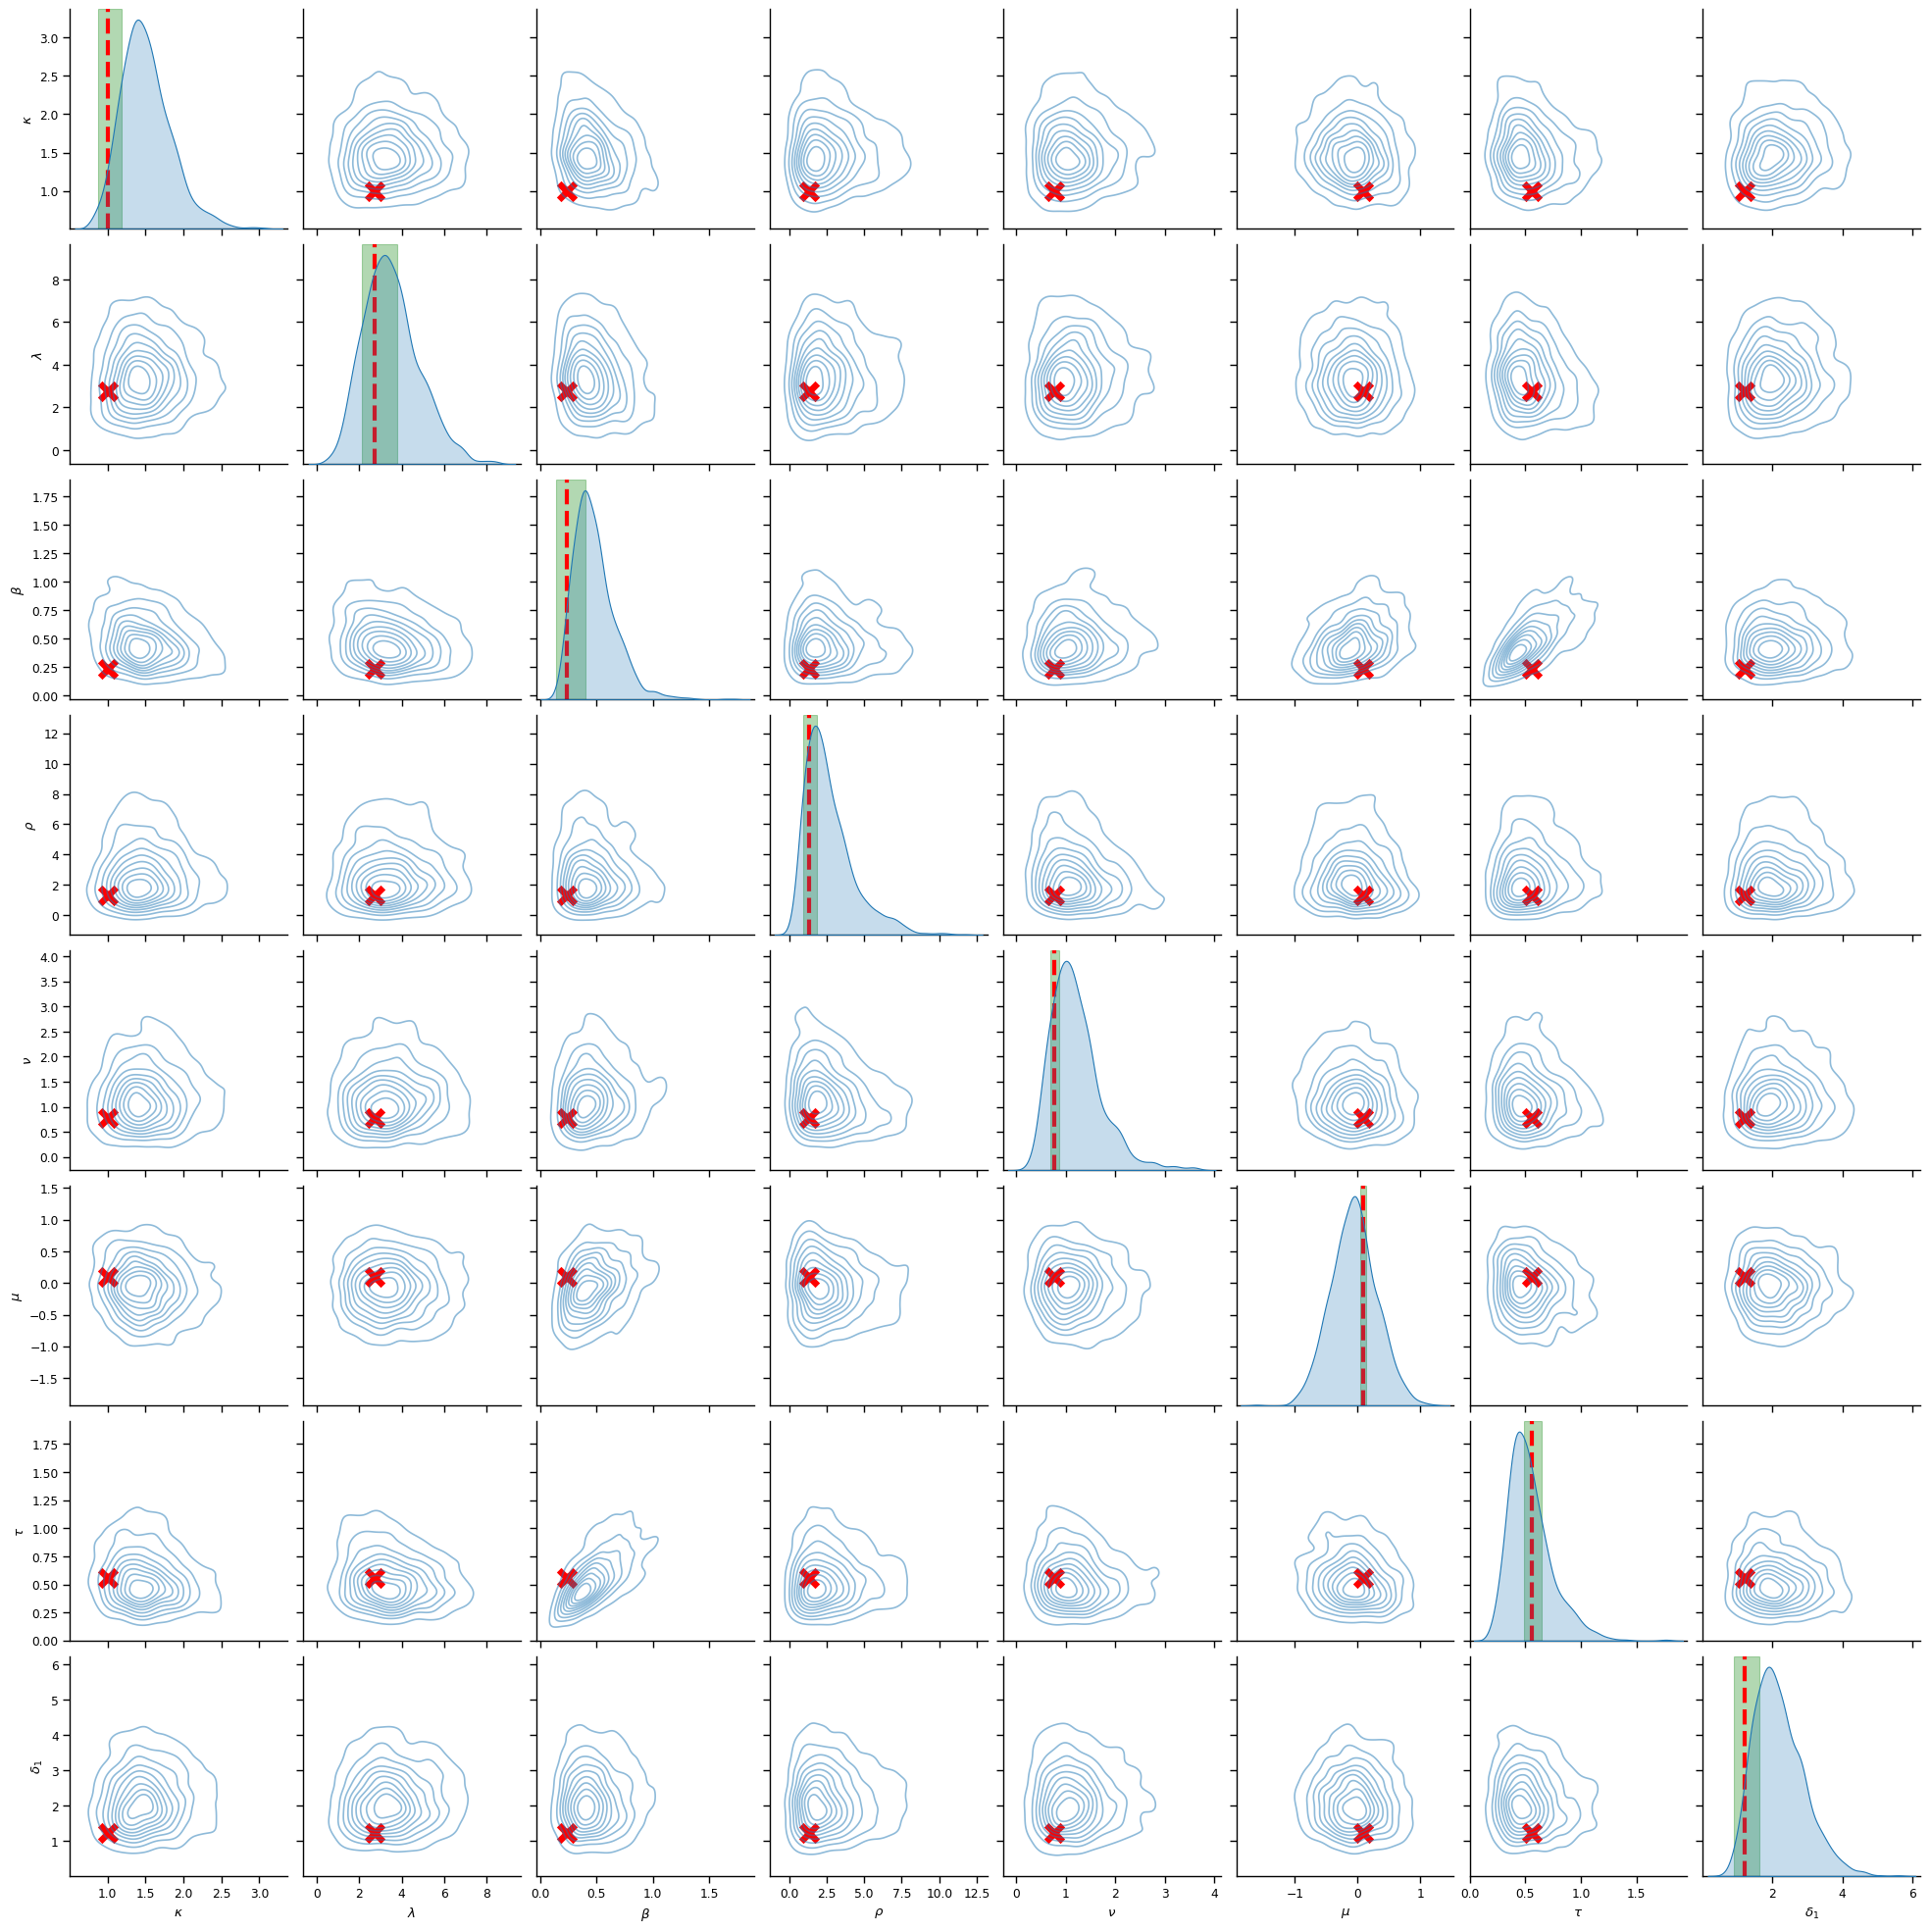

In [258]:
import seaborn as sns
plott = pd.DataFrame(post_df.detach().numpy())

sns.set_context("paper")
g = sns.pairplot(plott, kind = "kde", plot_kws={'alpha': 0.5})
g.data = point_est.T
g.map_offdiag(sns.scatterplot, color = "red", marker = 'X', s = 300)

labels = [r'$\kappa$',r'$\lambda$',r'$\beta$',r'$\rho$',r'$\nu$',r'$\mu$',r'$\tau$',r'$\delta_1$']

for i in range(8):
    for j in range(8):
        g.axes[j,i].xaxis.set_label_text(labels[i])
        g.axes[j,i].yaxis.set_label_text(labels[j])


k = 0
for i,ax in enumerate(g.axes.ravel()):
    if i % 8 == k and i // 8 == k:
        k += 1
        #print(ax)
        ax.axvline(point_est.T[k-1][0], ls='--', linewidth=3, c='red')
        ax.axvspan(point_est_lwr.T[k-1][0],point_est_upr.T[k-1][0], color='green',alpha=0.3)
        #ax.axvline(point_est_upr.T[k-1][0], ls='dotted', linewidth=3, c='green')


torch.Size([1, 1, 29, 37])


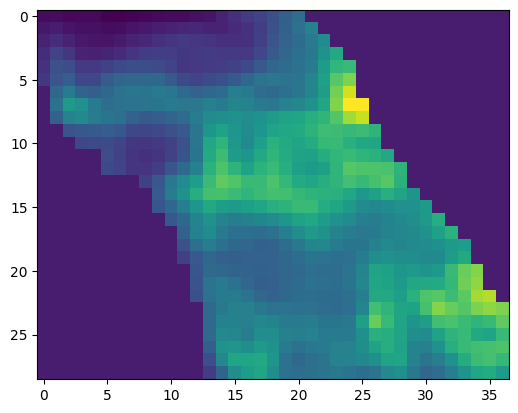

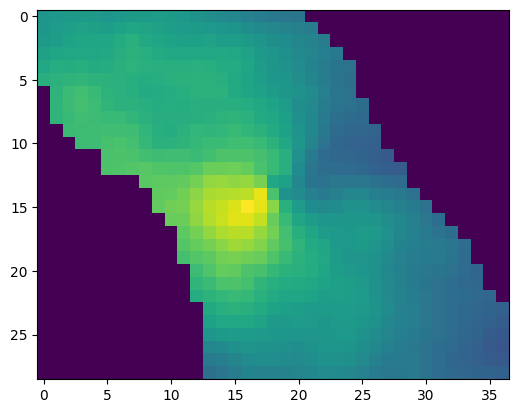

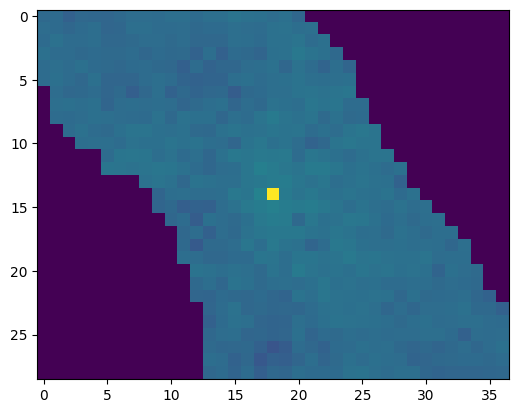

In [44]:
current_obs = 4
#good res. ex.: 65

sim_avg = simulator(torch.mean(posterior[current_obs,0,], dim=0).detach())
sim_var = simulator(torch.var(posterior[current_obs,0,], dim=0).detach())
print(sim_avg.shape)

plt.imshow(obs_test_tensor[current_obs][0])
plt.show()
plt.imshow(sim_avg[0][0])
plt.show()
plt.imshow(sim_var[0][0])
plt.show()

In [225]:
print(posterior.shape)
##penumerate(torch.cat((posterior.reshape(1410,1,8)[:426] ,posterior.reshape(1410,1,8)[427:475], posterior.reshape(1410,1,8)[476:987], posterior.reshape(1410,1,8)[988:])).detach())
#for idx, i in enumerate(posterior.reshape(1410,1,8)[988:].detach()):
#    print(idx)
#    simulator(i)
sim_grids =  torch.stack([simulator(obsval.detach()) 
                          for obsval in torch.cat((posterior.squeeze(1).squeeze(2)[:42],posterior.squeeze(1).squeeze(2)[43:47],posterior.squeeze(1).squeeze(2)[48:98],posterior.squeeze(1).squeeze(2)[99:]))])

torch.Size([141, 1, 10, 1, 1, 8])


/home/bence/Internship/LFI_gen_networks_SRs/gatsbi/task_utils/RedSea/simulator.py:113: RuntimeWarning: invalid value encountered in true_divide
  Y_hat_0_1 = Y_hat_0 / std_dev_proc(h, rho, nu)[s0_idx]


In [226]:
sim_grids.shape

torch.Size([138, 10, 1, 29, 37])

In [229]:
#sim_grid_ok = torch.cat((sim_grids[:][:420],sim_grids[:][429:469],sim_grids[:][478:978], sim_grids[987:])).reshape(138,10,29,37).flatten(2,-1)
obs_ok = torch.cat((obs_test_tensor[:42],obs_test_tensor[43:47],obs_test_tensor[:][48:98], obs_test_tensor[99:])).flatten(1,-1)

print(sim_grids.squeeze(2).shape)
print(obs_ok.shape)

res_gennet = compute_calibration_metrics(sim_grids.squeeze(2).flatten(2,-1),obs_ok, norm_rmse=False)



torch.Size([138, 10, 29, 37])
torch.Size([138, 1073])


In [230]:
res_gennet

{'cal_err_val_mean': 0.20872506989748368,
 'r2_val_mean': 0.35737764981969306,
 'rmse_val_mean': 0.8361135,
 'cal_err_val_std': 0.22668589247004145,
 'r2_val_std': 0.5100985797704307,
 'rmse_val_std': 0.6447629}

In [231]:
def point_estimate_prior(num_samples: int, seed = 42):

    param_sample = np.ndarray((num_samples,8))
    
    kappa = (point_est.T[0][0], (point_est_upr.T[0][0] - point_est.T[0][0]))
    _lambda = (point_est.T[1][0], (point_est_upr.T[1][0] - point_est.T[1][0]))
    beta = (point_est.T[2][0], (point_est_upr.T[2][0] - point_est.T[2][0]))
    rho = (point_est.T[3][0], (point_est_upr.T[3][0] - point_est.T[3][0]))
    nu = (point_est.T[4][0], (point_est_upr.T[4][0] - point_est.T[4][0]))
    mu = (point_est.T[5][0], (point_est_upr.T[5][0] - point_est.T[5][0]))
    tau = (point_est.T[6][0], (point_est_upr.T[6][0] - point_est.T[6][0]))
    delta1 = (point_est.T[7][0], (point_est_upr.T[7][0] - point_est.T[7][0]))



    for idx, param in enumerate([kappa,
                                    _lambda,
                                    beta,
                                    rho,
                                    nu,
                                    mu,
                                    tau,
                                    delta1]):
        param_sample[:,idx] = np.random.normal(param[0],param[1],num_samples)
        
    return torch.FloatTensor(param_sample).unsqueeze(1)



In [232]:
point_est_param = point_estimate_prior(1380)


point_est_sim = simulator(point_est_param)



/home/bence/Internship/LFI_gen_networks_SRs/gatsbi/task_utils/RedSea/simulator.py:113: RuntimeWarning: invalid value encountered in true_divide
  Y_hat_0_1 = Y_hat_0 / std_dev_proc(h, rho, nu)[s0_idx]
/home/bence/Internship/LFI_gen_networks_SRs/gatsbi/task_utils/RedSea/simulator.py:30: RuntimeWarning: invalid value encountered in power
  return z * np.exp(-(np.apply_along_axis(np.linalg.norm, 1, h) / lam) ** kappa)


In [249]:
point_est_extra = point_estimate_prior(9)
point_est_extra_sim = simulator(point_est_extra)

/home/bence/Internship/LFI_gen_networks_SRs/gatsbi/task_utils/RedSea/simulator.py:113: RuntimeWarning: invalid value encountered in true_divide
  Y_hat_0_1 = Y_hat_0 / std_dev_proc(h, rho, nu)[s0_idx]


In [252]:
point_est_sim = torch.cat((point_est_sim[:303],
                           point_est_sim[304:400],
                           point_est_sim[401:432],
                           point_est_sim[433:600],
                           point_est_sim[601:832],
                           point_est_sim[833:1026],
                           point_est_sim[1027:1098],
                           point_est_sim[1099:1210],
                           point_est_sim[1211:1362],
                           point_est_sim[1363:],))
for idx,i in enumerate(point_est_sim):
    if torch.isnan(i).any().numpy():
        print(idx)
#res_pointest = compute_calibration_metrics(point_est_sim.reshape(138,10,29,37).flatten(2,-1),obs_ok, norm_rmse=False)


In [256]:
torch.cat((point_est_sim,point_est_extra_sim)).shape
res_pointest = compute_calibration_metrics(torch.cat((point_est_sim,point_est_extra_sim)).reshape(138,10,29,37).flatten(2,-1),obs_ok, norm_rmse=False)
res_pointest

{'cal_err_val_mean': 0.24064771668219942,
 'r2_val_mean': 0.20654153291524885,
 'rmse_val_mean': 0.93444854,
 'cal_err_val_std': 0.2038857674909497,
 'r2_val_std': 0.6125644818017096,
 'rmse_val_std': 0.7235305}